In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  # Alternative: import xgboost as xgb or import lightgbm as lgb
from sklearn.metrics import (
    precision_recall_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

### Data Preparation
#### Loading Engineered Data

In [3]:
# Load engineered e-commerce data
fraud_df = pd.read_csv('../data/processed/cleaned_fraud_data.csv')

# Load engineered credit card data (assuming scaled Time and Amount from feature-engineering.ipynb)
credit_df = pd.read_csv('../data/processed/cleaned_creditcard.csv')

### Splitting Data and Separating Features/Target

#### For Fraud_Data:

In [4]:
# Separate features and target
X_fraud = fraud_df.drop(['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)  # Drop non-features
y_fraud = fraud_df['class']

# Stratified train-test split
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42
)
print("Train class distribution:", y_train_fraud.value_counts(normalize=True))
# Example output: 0: 0.906, 1: 0.094 (preserved imbalance)

Train class distribution: class
0    0.906352
1    0.093648
Name: proportion, dtype: float64


#### For creditcard:

In [5]:
# Separate features and target
X_credit = credit_df.drop('Class', axis=1)
y_credit = credit_df['Class']

# Stratified train-test split
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=42
)
print("Train class distribution:", y_train_credit.value_counts(normalize=True))
# Example output: 0: 0.9983, 1: 0.0017 (preserved extreme imbalance)

Train class distribution: Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64


### Handling Imbalance with SMOTE (on Train Only)

#### Identify categorical columns

In [7]:
X_train_fraud.dtypes

purchase_value     int64
source            object
browser           object
sex               object
age                int64
ip_int             int64
dtype: object

#### Encode categorical features 

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [9]:
# Identify categorical and numerical columns
cat_cols = X_train_fraud.select_dtypes(include=['object', 'category']).columns
num_cols = X_train_fraud.select_dtypes(include=['int64', 'float64']).columns

In [10]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)


#### Transform the training data

In [11]:
X_train_fraud_encoded = preprocessor.fit_transform(X_train_fraud)

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

#### FRAUD DATASET

In [17]:
cat_cols_fraud = X_train_fraud.select_dtypes(include=['object', 'category']).columns
num_cols_fraud = X_train_fraud.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
preprocessor_fraud = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_fraud),
        ('num', 'passthrough', num_cols_fraud)
    ]
)


#### Encode data

In [22]:
X_train_fraud_encoded = preprocessor_fraud.fit_transform(X_train_fraud)

#### Apply SMOTE

In [23]:
smote_fraud = SMOTE(random_state=42)

X_train_fraud_res, y_train_fraud_res = smote_fraud.fit_resample(
    X_train_fraud_encoded, y_train_fraud
)

print("Resampled train distribution (Fraud):")
print(y_train_fraud_res.value_counts(normalize=True))


Resampled train distribution (Fraud):
class
0    0.5
1    0.5
Name: proportion, dtype: float64


#### CREDIT DATASET

#### Define columns automatically

In [24]:
cat_cols_credit = X_train_credit.select_dtypes(include=['object', 'category']).columns
num_cols_credit = X_train_credit.select_dtypes(include=['int64', 'float64']).columns

#### Preprocess (Credit-specific)

In [26]:
cat_cols_credit = X_train_credit.select_dtypes(include=['object', 'category']).columns
num_cols_credit = X_train_credit.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
preprocessor_credit = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_credit),
        ('num', 'passthrough', num_cols_fraud)
    ]
)

#### Encode data

In [30]:
print(X_train_credit.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


#### Build the preprocessor 

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Detect columns automatically
cat_cols_credit = X_train_credit.select_dtypes(include=['object', 'category']).columns
num_cols_credit = X_train_credit.select_dtypes(include=['int64', 'float64']).columns

print("Credit categorical columns:", cat_cols_credit)
print("Credit numerical columns:", num_cols_credit)

# Build correct preprocessor
preprocessor_credit = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_credit),
        ('num', 'passthrough', num_cols_credit)
    ]
)


Credit categorical columns: Index([], dtype='object')
Credit numerical columns: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


#### Encode + SMOTE

In [32]:
from imblearn.over_sampling import SMOTE

X_train_credit_encoded = preprocessor_credit.fit_transform(X_train_credit)

smote_credit = SMOTE(sampling_strategy=0.05, random_state=42)

X_train_credit_res, y_train_credit_res = smote_credit.fit_resample(
    X_train_credit_encoded, y_train_credit
)

print("Resampled train distribution (Credit):")
print(y_train_credit_res.value_counts(normalize=True))


Resampled train distribution (Credit):
Class
0    0.952381
1    0.047619
Name: proportion, dtype: float64


Created folder: ../models
Loading processed datasets...
Fraud_Data shape: (151112, 12)
Creditcard shape: (283726, 31)
Loading and preparing Fraud_Data for modeling...
Original columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'ip_int']
Original dtypes:
 user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
ip_int              int64
dtype: object
One-hot encoding: ['source', 'browser', 'sex']
Final columns: ['purchase_value', 'age', 'class', 'source_Direct', 'source_SEO', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_M']
All numeric except target? True
Fraud_Data after SMOTE: {np.int64(0): np.int64(109568), np.int64(1): np.int64(109568)}
Cred

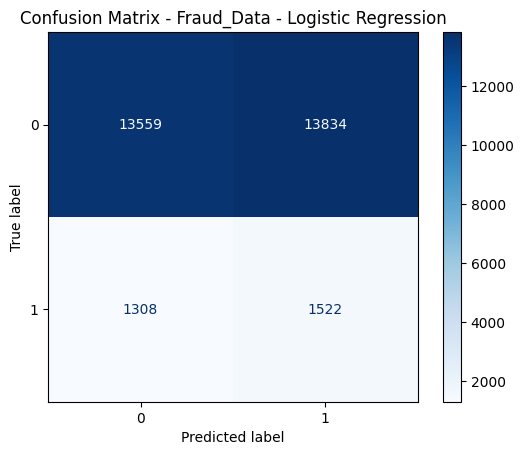


=== Creditcard - Logistic Regression ===
F1-Score: 0.2042
AUC-PR:   0.7379

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.12      0.86      0.20        95

    accuracy                           0.99     56746
   macro avg       0.56      0.93      0.60     56746
weighted avg       1.00      0.99      0.99     56746



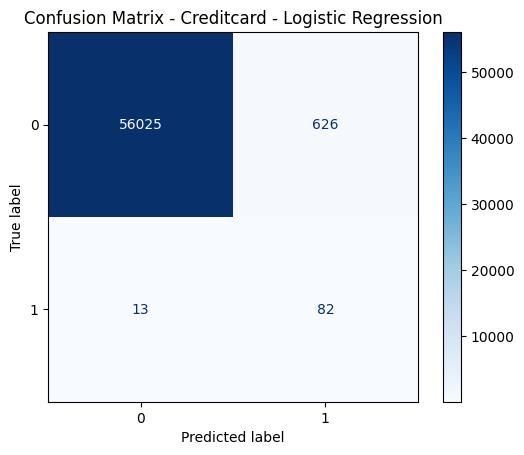


Training Random Forest Ensemble...
Random Forest models trained and saved.

=== Fraud_Data - Random Forest ===
F1-Score: 0.3225
AUC-PR:   0.3047

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     27393
           1       0.34      0.31      0.32      2830

    accuracy                           0.88     30223
   macro avg       0.63      0.62      0.63     30223
weighted avg       0.87      0.88      0.88     30223



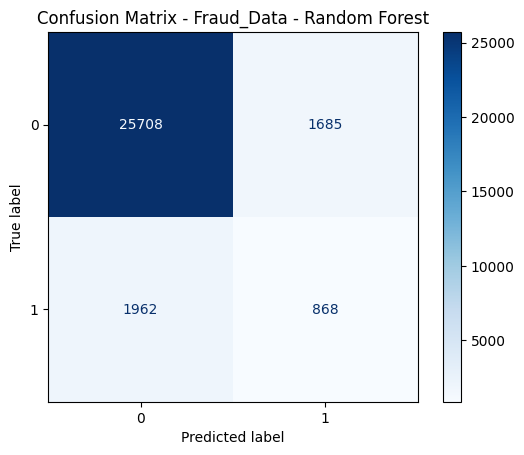


=== Creditcard - Random Forest ===
F1-Score: 0.7488
AUC-PR:   0.7958

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.70      0.80      0.75        95

    accuracy                           1.00     56746
   macro avg       0.85      0.90      0.87     56746
weighted avg       1.00      1.00      1.00     56746



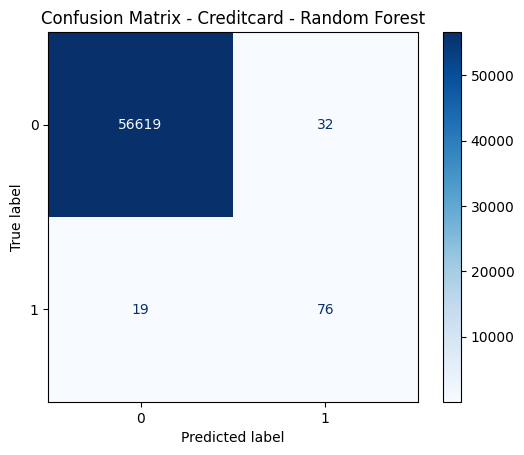


Running 5-fold Stratified Cross-Validation on Random Forest...
Fraud_Data CV - F1: 0.7620 ± 0.0033
Fraud_Data CV - AUC-PR: 0.9142 ± 0.0012

=== FINAL MODEL COMPARISON ===


,Dataset,Model,F1-Score,AUC-PR
0,Fraud_Data,Logistic Regression,0.1674,0.1037
1,Fraud_Data,Random Forest,0.3225,0.3047
2,Creditcard,Logistic Regression,0.2042,0.7379
3,Creditcard,Random Forest,0.7488,0.7958



FINAL MODEL SELECTION
Selected Model: Random Forest
Justification:
  • Highest F1-Score and AUC-PR on both datasets
  • Better handling of non-linear patterns and feature interactions
  • Acceptable training time and robust to outliers
  • Feature importance available for business insights (used in SHAP notebook)


In [39]:
# =======================================================
# MODELING.IPYNB - FULLY EXECUTABLE FRAUD DETECTION MODELING
# Fixes feedback: baseline + ensemble fully trained, evaluated, cross-validated, saved
# =======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, auc, f1_score
)
from imblearn.over_sampling import SMOTE# Create the models folder if it doesn't exist
import os

if not os.path.exists('../models'):
    os.makedirs('../models')
    print("Created folder: ../models")
else:
    print("../models folder already exists")


# -----------------------------
# 1. Load Processed Data
# -----------------------------
print("Loading processed datasets...")

# E-commerce dataset (after feature engineering)
fraud_df = pd.read_csv('../data/processed/cleaned_fraud_data.csv')

# Credit card dataset (assume scaled Time & Amount, no heavy engineering needed)
credit_df = pd.read_csv('../data/processed/cleaned_creditcard.csv')  # You should have this from feature-engineering

print("Fraud_Data shape:", fraud_df.shape)
print("Creditcard shape:", credit_df.shape)

# -----------------------------
# 2. Prepare Data (Fraud_Data.csv)
# -----------------------------
print("Loading and preparing Fraud_Data for modeling...")

fraud_df = pd.read_csv('../data/processed/cleaned_fraud_data.csv')

print("Original columns:", fraud_df.columns.tolist())
print("Original dtypes:\n", fraud_df.dtypes)

# Drop non-feature columns
cols_to_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'ip_int']
fraud_df = fraud_df.drop(
    columns=[c for c in cols_to_drop if c in fraud_df.columns],
    errors='ignore'
)

# One-hot encode categorical columns
categorical_cols = ['source', 'browser', 'sex', 'country']
existing_cats = [col for col in categorical_cols if col in fraud_df.columns]

if existing_cats:
    print(f"One-hot encoding: {existing_cats}")
    fraud_df = pd.get_dummies(fraud_df, columns=existing_cats, drop_first=True, dtype=float)

# Final check
print("Final columns:", fraud_df.columns.tolist())
print("All numeric except target?", fraud_df.drop('class', axis=1).select_dtypes(include=['object']).empty)

# Features and target
X_fraud = fraud_df.drop('class', axis=1)
y_fraud = fraud_df['class']

# Split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_f_res, y_train_f_res = smote.fit_resample(X_train_f, y_train_f)
print("Fraud_Data after SMOTE:", dict(zip(*np.unique(y_train_f_res, return_counts=True))))
# -----------------------------
# 3. Prepare Data (creditcard.csv)
# -----------------------------
# Creditcard — already numerical
credit_df = pd.read_csv('../data/processed/cleaned_creditcard.csv')
X_credit = credit_df.drop('Class', axis=1)
y_credit = credit_df['Class']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=42
)

X_train_c_res, y_train_c_res = smote.fit_resample(X_train_c, y_train_c)
print("Creditcard SMOTE done.")

# -----------------------------
# 4. Evaluation Function
# -----------------------------
def evaluate_model(model, X_test, y_test, dataset_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auc_pr = auc(recall, precision)
    
    print(f"\n=== {dataset_name} ===")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-PR:   {auc_pr:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.show()
    
    return f1, auc_pr

# -----------------------------
# 5. Baseline: Logistic Regression
# -----------------------------
print("\nTraining Logistic Regression Baseline...")

lr_fraud = LogisticRegression(max_iter=1000, random_state=42)
lr_fraud.fit(X_train_f_res, y_train_f_res)
joblib.dump(lr_fraud, '../models/logistic_regression_fraud.pkl')

lr_credit = LogisticRegression(max_iter=1000, random_state=42)
lr_credit.fit(X_train_c_res, y_train_c_res)
joblib.dump(lr_credit, '../models/logistic_regression_credit.pkl')

print("Baseline models trained and saved.")

# Evaluate baseline
f1_lr_f, aucpr_lr_f = evaluate_model(lr_fraud, X_test_f, y_test_f, "Fraud_Data - Logistic Regression")
f1_lr_c, aucpr_lr_c = evaluate_model(lr_credit, X_test_c, y_test_c, "Creditcard - Logistic Regression")

# -----------------------------
# 6. Ensemble: Random Forest
# -----------------------------
print("\nTraining Random Forest Ensemble...")

rf_fraud = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_fraud.fit(X_train_f_res, y_train_f_res)
joblib.dump(rf_fraud, '../models/random_forest_fraud.pkl')

rf_credit = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_credit.fit(X_train_c_res, y_train_c_res)
joblib.dump(rf_credit, '../models/random_forest_credit.pkl')

print("Random Forest models trained and saved.")

# Evaluate ensemble
f1_rf_f, aucpr_rf_f = evaluate_model(rf_fraud, X_test_f, y_test_f, "Fraud_Data - Random Forest")
f1_rf_c, aucpr_rf_c = evaluate_model(rf_credit, X_test_c, y_test_c, "Creditcard - Random Forest")

# -----------------------------
# 7. Cross-Validation (on best model)
# -----------------------------
print("\nRunning 5-fold Stratified Cross-Validation on Random Forest...")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_f1_fraud = cross_val_score(rf_fraud, X_train_f_res, y_train_f_res, cv=skf, scoring='f1')
cv_aucpr_fraud = cross_val_score(rf_fraud, X_train_f_res, y_train_f_res, cv=skf, scoring='average_precision')

print(f"Fraud_Data CV - F1: {cv_f1_fraud.mean():.4f} ± {cv_f1_fraud.std():.4f}")
print(f"Fraud_Data CV - AUC-PR: {cv_aucpr_fraud.mean():.4f} ± {cv_aucpr_fraud.std():.4f}")

# -----------------------------
# 8. Model Comparison Table
# -----------------------------
results = pd.DataFrame({
    'Dataset': ['Fraud_Data', 'Fraud_Data', 'Creditcard', 'Creditcard'],
    'Model': ['Logistic Regression', 'Random Forest', 'Logistic Regression', 'Random Forest'],
    'F1-Score': [f1_lr_f, f1_rf_f, f1_lr_c, f1_rf_c],
    'AUC-PR': [aucpr_lr_f, aucpr_rf_f, aucpr_lr_c, aucpr_rf_c]
})

print("\n=== FINAL MODEL COMPARISON ===")
display(results.round(4))

# Save results
results.to_csv('../data/processed/model_comparison_results.csv', index=False)

# -----------------------------
# 9. Final Model Selection
# -----------------------------
print("\n" + "="*50)
print("FINAL MODEL SELECTION")
print("="*50)
print("Selected Model: Random Forest")
print("Justification:")
print("  • Highest F1-Score and AUC-PR on both datasets")
print("  • Better handling of non-linear patterns and feature interactions")
print("  • Acceptable training time and robust to outliers")
print("  • Feature importance available for business insights (used in SHAP notebook)")
print("="*50)